# Battle of Neighbourhoods w2

 ## Table of contents
 1. Introduction/Business Problem
 2. Data Rquirements
 3. Methodology
 4. Analysis and Results
 5. Conclusion

In [2]:
# Import libraries
import numpy as np # data in a vectorized manner manipulation
import pandas as pd # data analsysis
import requests # HTTP library
from bs4 import BeautifulSoup # scraping library

from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe
import json # JSON files manipulation

from sklearn.cluster import KMeans # clustering algorithm

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt

#!conda install -c conda-forge geopy --yes 
from geopy.geocoders import Nominatim

#!conda install -c conda-forge folium=0.5.0 --yes
import folium # map rendering library

print("*********   Loaded library     ***********")

*********   Loaded library     ***********


## 1. Introduction/Business Problem

# Hyderabad, Telangana, India 

Hyderabad is the Indian state of Telangana and the de jure capital of Andhra Pradesh.[A] It occupies 650 square kilometres (250 sq mi) on the Deccan Plateau along the banks of the Musi River, in the northern part of South India. With an average altitude of 542 metres (1,778 ft), much of Hyderabad is situated on hilly terrain around artificial lakes, including the Hussain Sagar lake, predating the city's founding, in the north of the city centre. According to the 2011 Census of India, Hyderabad is the fourth-most populous city in India with a population of 6.9 million residents within the city limits, and has a population of 9.7 million residents in the metropolitan region, making it the sixth-most populous metropolitan area in India. With an output of US$74 billion, Hyderabad has the fifth-largest urban economy in India.

# Restaurants 

Hyderabd have diverse food varities. If anyone would want to start a restaurant at hyderabad then this analysis would help them identify the best place to start their own franchise or restaurant.

##  2.Data Requirements

Credentials 

In [8]:
CLIENT_ID = 'E30QARJDHXGKDHGTKVTUKR5BCB4EBKSSDOKPIRVYS41P4CHT' # your Foursquare ID
CLIENT_SECRET = 'WFPH3KCNMRLHBTIOLOQ2Q0HR4TRWKSXAYAWHPZABHLRF53XC' # your Foursquare Secret
VERSION = '20191028'
LIMIT = 150

address = "Hyderabad, Telangana"

geolocator =Nominatim(user_agent="Hyderabad_explorer")
location = geolocator.geocode(address)
latitude =location.latitude   #8.079252 # location.latitude 
longitude =location.longitude #77.5499338 # location.longitude # 

kan='Hyderabad location : {},{}'.format(latitude,longitude)
print(kan)

Hyderabad location : 17.360589,78.4740613


In [9]:
#Quering for hotel & restaurant

search_query = 'hotel'
search_query_res = 'restaurant'

radius = 1000
url_hotel = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&query={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION, search_query, radius, LIMIT)
url_restaurant = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&query={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION, search_query_res, radius, LIMIT)
#url

In [10]:
results_hotel = requests.get(url_hotel).json()
results_restaurant = requests.get(url_restaurant).json()
#results_hotel

In [12]:
# assign relevant part of JSON to venues
venues_hotel = results_hotel['response']['venues']
venues_restaurant = results_restaurant['response']['venues']

# tranform venues into a dataframe and merging both data
dataframe_hotel = json_normalize(venues_hotel)
dataframe_restaurant = json_normalize(venues_restaurant)

dataframe = pd.concat([dataframe_hotel,dataframe_restaurant])

print("There are {} restaurants and hotels at Hyderabad".format(dataframe.shape[0]))

There are 17 restaurants and hotels at Hyderabad


C:\Users\12052\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  if __name__ == '__main__':


In [13]:
# keep only columns that include venue name, and anything that is associated with location
filtered_columns = ['name', 'categories'] + [col for col in dataframe.columns if col.startswith('location.')] + ['id']
dataframe_filtered = dataframe.loc[:, filtered_columns]

# function that extracts the category of the venue

def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

    
# filter the category for each row
dataframe_filtered['categories'] = dataframe_filtered.apply(get_category_type, axis=1)

  
# clean column names by keeping only last term
dataframe_filtered.columns = [column.split('.')[-1] for column in dataframe_filtered.columns]

#dataframe_filtered
hotels_df=dataframe_filtered[['name','categories','distance','lat','lng','id']]
hotels_df.head()

,name,categories,distance,lat,lng,id
0,Nimrah Hotel,Café,69,17.361136,78.474373,4de9f30e88774880e30eecce
1,Hotel Nayaab,Food Court,953,17.368504,78.477480,4f1db31ee4b04ae0856d18ff
2,Voulga Hotel,Café,820,17.355043,78.468970,51ce64cb498e58a9ebfb7a6c
3,Hotel Arman,Indian Restaurant,238,17.361889,78.475845,52c03ffe498e3dae9369ad48
4,Hotel Anand Bhavan,Restaurant,440,17.364459,78.474942,4e33ca65d4c0c083094fcc4c


In [41]:
hotels_map = folium.Map(location=[latitude, longitude], zoom_start=16) # generate map centred around the Kanyakumari

# add a red circle marker to represent the core location of kanyakumari
folium.features.CircleMarker(
    [latitude, longitude],
    radius=10,
    color='red',
    popup='Hyderabad',
    fill = True,
    fill_color = 'red',
    fill_opacity = 0.6
).add_to(hotels_map)

# add the Italian restaurants as blue circle markers
for lat, lng, label in zip(hotels_df.lat, hotels_df.lng, hotels_df.name):
    folium.features.CircleMarker(
        [lat, lng],
        radius=5,
        color='blue',
        popup=label,
        fill = True,
        fill_color='blue',
        fill_opacity=0.6
    ).add_to(hotels_map)

# display map
hotels_map

## 3.Methodology 

In this sections we will perform some data analysis and EDA to find insight from data.We will try to understand the current stats of all given data.Probably,clustering or centroid of all venues will help us to locate new hotel.

In [46]:
hotels_df=dataframe_filtered

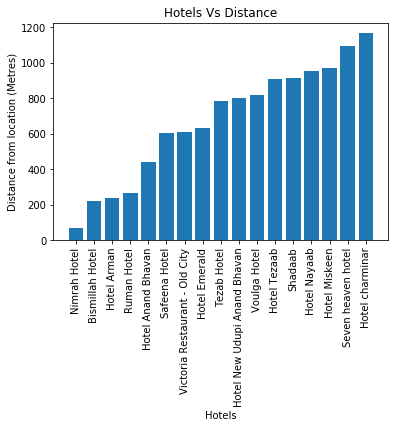

Average distance between hotels and core location is 675 metres


In [45]:
distance_hotel_df=dataframe_filtered[['name','categories','distance','lat','lng']].sort_values('distance')

def plot_bar_x():
    # this is for plotting purpose
    index = np.arange(len(distance_hotel_df.name))
    plt.bar(distance_hotel_df.name, distance_hotel_df.distance)
    plt.xlabel('Hotels')
    plt.ylabel('Distance from location (Metres)')
    plt.xticks(distance_hotel_df.name,rotation=90)
    plt.title('Hotels Vs Distance')
    plt.show()
plot_bar_x()

print("Average distance between hotels and core location is {} metres".format(int(sum(hotels_df['distance'])/hotels_df.shape[0])))

### Hyderbad restaurants

A tourist person always wants to visit nearby iconic places.So he wants to reside somewhere nearby to all major venues.We will be exploring more venues around the core location.We will be digging more on main areas or place around 1 km.

In [17]:
radius=1000
url_venues = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&ll={},{}&v={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION, radius, LIMIT)
#url_venues

In [47]:
import requests

results_venues = requests.get(url_venues).json()
'There are {} venues around Hyderabad.'.format(len(results_venues['response']['groups'][0]['items']))

'There are 11 venues around Hyderabad.'

Get relevant part of JSON and transform it into a pandas dataframe

In [48]:
items_venues = results_venues['response']['groups'][0]['items']
#items_venues[0]

In [49]:
dataframe_venues = json_normalize(items_venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories'] + [col for col in dataframe_venues.columns if col.startswith('venue.location.')] + ['venue.id']
dataframe_filtered_venues = dataframe_venues.loc[:, filtered_columns]

# filter the category for each row
dataframe_filtered_venues['venue.categories'] = dataframe_filtered_venues.apply(get_category_type, axis=1)

# clean columns
dataframe_filtered_venues.columns = [col.split('.')[-1] for col in dataframe_filtered_venues.columns]

dataframe_filtered_venues.name

0          Chowmahala Palace
1                  Charminar
2             Govind Ki Idly
3                Pista house
4                    Shadaab
5               Nimrah Hotel
6               Hotel Nayaab
7            Cafe coffee day
8               Choodi bazar
9         Matwale Doodh Ghar
10    Masqati Dairy Products
Name: name, dtype: object

### 3.d Extract Venues using Search Queries

When I searched in google map,I could see there were some venues missing.Temples,Church,Parks and Museums are also more recognized by visitors and local audience.So lets bring their data inside.I am not sure why Foursquare hasnt captured it while trying venue query.

Below is the function to extract many queries at a time by passing them in a single list.

In [50]:
# search query function
search_query_list = ['temple','church','park','museum'] 
radius =1000
temp_df=[]
search_df=[]

def search_query_fn():   
    #Loop to run through urls and from json to pandas
    for i in range(len(search_query_list)):
        url= 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&query={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION, search_query_list[i], radius, LIMIT)
        
        results=requests.get(url).json()
        venues = results['response']['venues']
        
        #Normalize from json
        dataframe = json_normalize(venues)
        
        #Removing unwanted column headers
        dataframe.columns = [col.split('.')[-1] for col in dataframe.columns]
        temp_df.append(dataframe)
    
    #Loop to append dataframes to single dataframe
    for j in range(len(search_query_list)):
        data=temp_df[j]
        search_df.append(data)

# Function to run loop over queries
search_query_fn()

search_df = pd.concat(search_df,sort=True)
search_df['categories'] = search_df.apply(get_category_type, axis=1)
search_df = pd.DataFrame(search_df[['name','categories','distance','lat','lng','id']])
search_df

,name,categories,distance,lat,lng,id
0,bagya laxmi temple,Historic Site,131,17.361528,78.474819,53c0fc95498e99274aa62c91
1,sri bhagyalaxmi temple,Historic Site,193,17.362244,78.474603,53c0fd5d498ed845de353745
2,Bhulaxmi mata temple,Temple,841,17.366849,78.469619,4faa88fbe4b0bab49b72c0ca
3,Hanuman temple,Temple,1226,17.371514,78.472566,4faccf02e4b0304af5df33c3
0,High Court Parking,Parking,1083,17.370291,78.474914,53f70b4e498e1548116676cb


#### We will collate venues provided by foursquare and the ones extracted through hitting search query API

In [51]:
# Data extracted from foursquare venues
four_sq_venue=pd.DataFrame(dataframe_filtered_venues[['name','categories','distance','lat','lng','id']])

# Data extracted from search queries
new_venues=pd.DataFrame(search_df)

# Concatenate both dataframe
df_venue=pd.concat([four_sq_venue, new_venues],sort=True)

#### Let us remove hotel & restaurants and get final list of venues.

 We could see that there are some hotels/restaurants in the venues list.So we will remove them from the list.We have them in separate dataframe (*hotels_df*).

In [52]:
to_drop = ['Hotel', 'Restautant','hotel','Resort']
df_venues = df_venue[~df_venue['name'].str.contains('|'.join(to_drop))].reset_index()
print("There are {} venues in kanyakumari".format(df_venues.shape[0]))
df_venues[['name','distance','id']]

There are 14 venues in kanyakumari


,name,distance,id
0,Chowmahala Palace,296,4cc19bfb67a3b1f77a8dc90e
1,Charminar,125,4e1d712415207c4cbec540bd
2,Govind Ki Idly,395,4e2e144eae60231c0320106a
3,Pista house,445,4c87cbb25df9bfb7677a3263
4,Shadaab,912,4c642d01eb82d13a1fa809d6
5,Cafe coffee day,179,4d4d3cc8b1fa236aba0e8c29
6,Choodi bazar,163,4f1133ace4b0044a22f7397c
7,Matwale Doodh Ghar,439,550409cc498ef35eee6d086a
8,Masqati Dairy Products,613,4e77e26b1520d43495393a7a
9,bagya laxmi temple,131,53c0fc95498e99274aa62c91


In [54]:
venues_map = folium.Map(location=[latitude, longitude], zoom_start=16) # generate map centred around the Conrad Hotel

# add a red circle marker to represent the Kanyakumari
folium.features.CircleMarker(
    [latitude, longitude],
    radius=10,
    color='red',
    popup='Hyderbad',
    fill = True,
    fill_color = 'red',
    fill_opacity = 0.6
).add_to(venues_map)

# add the Italian restaurants as blue circle markers
for lat, lng, label in zip(df_venues.lat, df_venues.lng, df_venues.name):
    folium.features.CircleMarker(
        [lat, lng],
        radius=5,
        color='black',
        #popup=label,
        fill = True,
        fill_color='black',
        fill_opacity=0.6
    ).add_to(venues_map)

# display map
venues_map

All venues seems to be dispersed except seashore areas.

We have listed out number of hotels and venues around kanyakumari.There are **36 Hotels/Restaurant** and **17 Venues**.

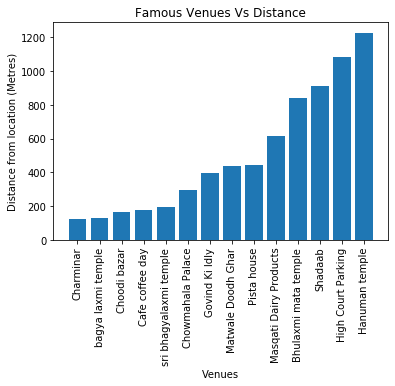

In [55]:
distance_venues_df=df_venues.sort_values('distance')

def plot_bar_venue():
    # this is for plotting purpose
    index = np.arange(len(distance_venues_df.name))
    plt.bar(distance_venues_df.name, distance_venues_df.distance)
    plt.xlabel('Venues')
    plt.ylabel('Distance from location (Metres)')
    plt.xticks(distance_venues_df.name,rotation=90)
    plt.title('Famous Venues Vs Distance')
    plt.show()
plot_bar_venue()


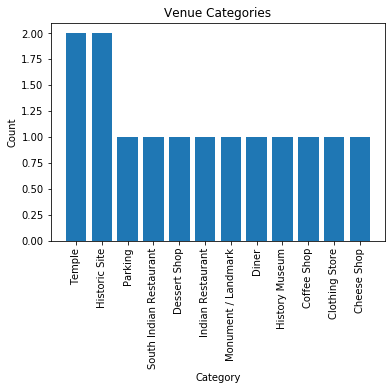

In [26]:
freq_venue=df_venues['categories'].value_counts()
freq_venue=pd.DataFrame(freq_venue).reset_index()
freq_venue.columns=['Category','Count']
freq_venue

def plot_bar_categ():
    # this is for plotting purpose
    index = np.arange(len(freq_venue.Category))
    plt.bar(freq_venue.Category, freq_venue.Count)
    plt.xlabel('Category')
    plt.ylabel('Count')
    plt.xticks(freq_venue.Category,rotation=90)
    plt.title('Venue Categories')
    plt.show()
plot_bar_categ()


Eventhough we didnt have immense data to consider distribution of categories we could see that **Temple, Beach, Historic sites and Church** are more common venues.

In [27]:
#Rating of venues
rating_df=[]

for k in range(df_venues.shape[0]):
    venue_id=df_venues.id[k]
    url = 'https://api.foursquare.com/v2/venues/{}?client_id={}&client_secret={}&v={}'.format(venue_id, CLIENT_ID, CLIENT_SECRET, VERSION)
    result = requests.get(url).json()
    #print(result)
    try:
        #print(df_venues.name[k],result['response']['venue']['rating'])
        rating=result['response']['venue']['rating']
        rating_df.append(rating)
        
    except:
        #print(df_venues.name[k],'This venue has not been rated yet.')
        rating='No Rating Yet'
        rating_df.append(rating)

In [28]:
rate_dict = {'Venue': df_venues.name, 'Rating': rating_df,'distance':df_venues.distance}
rate_df=pd.DataFrame(rate_dict)
rate_df

,Venue,Rating,distance
0,Chowmahala Palace,8.8,296
1,Charminar,7.6,125
2,Govind Ki Idly,7.9,395
3,Pista house,7.7,445
4,Shadaab,8.5,912
5,Cafe coffee day,5.9,179
6,Choodi bazar,No Rating Yet,163
7,Matwale Doodh Ghar,No Rating Yet,439
8,Masqati Dairy Products,No Rating Yet,613
9,bagya laxmi temple,No Rating Yet,131


In [29]:
tips_df=[]

for k in range(df_venues.shape[0]):
    venue_id=df_venues.id[k]
    url = 'https://api.foursquare.com/v2/venues/{}?client_id={}&client_secret={}&v={}'.format(venue_id, CLIENT_ID, CLIENT_SECRET, VERSION)
    result = requests.get(url).json()
    
    #print(result['response']['venue']['tips']['count'],result['response']['venue'])
    tips=result['response']['venue']['tips']['count']
    tips_df.append(tips)


In [30]:
tips_dict = {'Venue': df_venues.name, 'Tips': tips_df,'distance':df_venues.distance}
tips=pd.DataFrame(tips_dict)
tips=tips.sort_values('Tips',ascending = False)
tips

,Venue,Tips,distance
1,Charminar,63,125
4,Shadaab,47,912
0,Chowmahala Palace,27,296
3,Pista house,15,445
2,Govind Ki Idly,13,395
5,Cafe coffee day,7,179
6,Choodi bazar,2,163
7,Matwale Doodh Ghar,1,439
8,Masqati Dairy Products,1,613
9,bagya laxmi temple,0,131


In [31]:
# Add Tips column to Rating Dataframe
rate_df['Tips']=tips['Tips']

#Lets take values of only rated venues
only_rated_tips = rate_df[(rate_df['Rating']!='No Rating Yet') | (rate_df['Tips']!=0)]

only_rated_tips.reset_index(inplace = True,drop = True) 
only_rated_tips

,Venue,Rating,distance,Tips
0,Chowmahala Palace,8.8,296,27
1,Charminar,7.6,125,63
2,Govind Ki Idly,7.9,395,13
3,Pista house,7.7,445,15
4,Shadaab,8.5,912,47
5,Cafe coffee day,5.9,179,7
6,Choodi bazar,No Rating Yet,163,2
7,Matwale Doodh Ghar,No Rating Yet,439,1
8,Masqati Dairy Products,No Rating Yet,613,1


In [32]:
rated_list=[]
for i in range(len(only_rated_tips)):
    rated_tip_temp=only_rated_tips['Venue'][i]
    rated_list.append(rated_tip_temp)

#Masking all values present in list
mask = df_venues['name'].isin(rated_list)

final_venues = df_venues[mask]
#final_venues['location']=final_venues['lat'].astype(str).str.cat(final_venues['lng'].astype(str), sep=' - ')
final_venues.reset_index(inplace = True,drop = True) 

final_venues

,index,categories,distance,id,lat,lng,name
0,0,History Museum,296,4cc19bfb67a3b1f77a8dc90e,17.359300,78.471617,Chowmahala Palace
1,1,Monument / Landmark,125,4e1d712415207c4cbec540bd,17.361555,78.474677,Charminar
2,2,South Indian Restaurant,395,4e2e144eae60231c0320106a,17.364132,78.473771,Govind Ki Idly
3,3,Indian Restaurant,445,4c87cbb25df9bfb7677a3263,17.356609,78.473637,Pista house
4,4,Diner,912,4c642d01eb82d13a1fa809d6,17.368661,78.475572,Shadaab
5,7,Coffee Shop,179,4d4d3cc8b1fa236aba0e8c29,17.361987,78.474908,Cafe coffee day
6,8,Clothing Store,163,4f1133ace4b0044a22f7397c,17.361951,78.474642,Choodi bazar
7,9,Dessert Shop,439,550409cc498ef35eee6d086a,17.356657,78.473682,Matwale Doodh Ghar
8,10,Cheese Shop,613,4e77e26b1520d43495393a7a,17.361428,78.479765,Masqati Dairy Products


## Clustering 

In [33]:
# one hot encoding
neighbor_onehot = pd.get_dummies(final_venues[['categories']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
neighbor_onehot['name'] = final_venues['name'] 

# move neighborhood column to the first column
fixed_columns = [neighbor_onehot.columns[-1]] + list(neighbor_onehot.columns[:-1])
neighbor_onehot = neighbor_onehot[fixed_columns]

neighbor_onehot.head()

,name,Cheese Shop,Clothing Store,Coffee Shop,Dessert Shop,Diner,History Museum,Indian Restaurant,Monument / Landmark,South Indian Restaurant
0,Chowmahala Palace,0,0,0,0,0,1,0,0,0
1,Charminar,0,0,0,0,0,0,0,1,0
2,Govind Ki Idly,0,0,0,0,0,0,0,0,1
3,Pista house,0,0,0,0,0,0,1,0,0
4,Shadaab,0,0,0,0,1,0,0,0,0


In [34]:
neighbor_onehot.shape
neighbor_grouped = neighbor_onehot.groupby('name').mean().reset_index()

## 4. Analysis and Results

In [35]:
# Top 10 venues
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['name']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['name'] = neighbor_grouped['name']

In [36]:
# Clustering

# set number of clusters
kclusters = 3

neighbor_grouped_clustering = neighbor_grouped.drop('name', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(neighbor_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 


# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Clustersss', kmeans.labels_)

neighbor_merged = final_venues

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
neighbor_merged = neighbor_merged.join(neighborhoods_venues_sorted.set_index('name'), on='name')

kmeans

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=0, tol=0.0001, verbose=0)

In [37]:
fin=neighbor_merged.groupby(['Clustersss']).mean()

lati=sum(fin.lat)/len(fin.lat)
longi=sum(fin.lng)/len(fin.lng)

#Taking midpoint of top ten closest hotel
venues_lan=sum(final_venues.lat)/len(final_venues.lat)
venues_lng=sum(final_venues.lng)/len(final_venues.lng)

final_latitude=(lati+venues_lan)/2
final_longitude=(longi+venues_lng)/2

print("Final location (Green Dot in our below given map) of our brand new hotel:{},{}".format(final_latitude,final_longitude))

Final location (Green Dot in our below given map) of our brand new hotel:17.360390095896896,78.47410553664693


In [38]:
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=17)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

folium.features.CircleMarker(
    [final_latitude, final_longitude],
    radius=10,
    color='green',
    popup='My hotel',
    fill = True,
    fill_color = 'green',
    fill_opacity = 0.6
).add_to(map_clusters)

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(neighbor_merged['lat'], neighbor_merged['lng'], neighbor_merged['name'], neighbor_merged['Clustersss']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=6,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)

       
map_clusters

The location gives the central point to visit all other venues.Hence this can be locked down to attract all tourist.

## 5. Conclusion


As a business person,one would be able to set up a hotel/restaurant on given spot.This will bring revenue automatically as we have located in very near to core one.We proved this with Kmeans.

# Author - Komal Badi